<a href="https://colab.research.google.com/github/Javier-HAZ/Machine-Learning-Projects-MITx-6.86x-/blob/main/CompVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Intro to computer vision**



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# **Practical Applications**

Cats and Dogs Classifier

## **From Kaggle**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xavihaz","key":"635827fabd4c799ba1e52eec03613bcb"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 35.0MB/s]
100% 542M/543M [00:03<00:00, 180MB/s]
100% 543M/543M [00:03<00:00, 174MB/s]
 93% 252M/271M [00:01<00:00, 205MB/s]
100% 271M/271M [00:01<00:00, 177MB/s]


In [ ]:
!unzip -qq train.zip

In [ ]:
!unzip -qq test1.zip

## **We are going to work with a small fraction of the entire dataset**

* Training: 1000 each (cats and dogs)
* Validation: 500 each
* Test: 1000 each


In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [ ]:
def make_subset(subset_name, start_index, end_index):
 for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
        shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [ ]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# **Building the model**:
Sequence of Conv and Maxpool layers

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# **Data Preprocessing**
We have the data as JPEG files, we need to transform it into tensors.

* Read the picture files
* Decode images to RGB grids of pixels
* Convert -> floating point tensors
* Reshape -> (180, 180, 3)
* Make batch-sizes of 32
A keras function is very useful in this process: image_dataset_from_directory(directory)


## **How does it work?**

Calling image_dataset_from_directory(directory) will first list the subdirectories of directory and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a tf.data.Dataset object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir / "train",
                                             image_size = (180, 180),
                                             batch_size = 32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation",
                                                  image_size = (180, 180),
                                                  batch_size = 32)
test_dataset = image_dataset_from_directory(new_base_dir / "test",
                                            image_size = (180, 180),
                                            batch_size = 32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Displaying the shape of the data and labels yielded by the DataSet

In [ ]:
for data_batch, label_batch in train_dataset:
    print("data batch shape: ", data_batch.shape)
    print("data labels shape: ", label_batch.shape)
    break

data batch shape:  (32, 180, 180, 3)
data labels shape:  (32,)


#**Training**

Fitting the model using a Dataset

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch.keras",
                                              save_best_only=True,
                                              monitor="val_loss")]

In [ ]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks = callbacks)

Epoch 1/30
63/63 [==============================] - 19s 126ms/step - loss: 0.7507 - accuracy: 0.5105 - val_loss: 0.6892 - val_accuracy: 0.5180
Epoch 2/30
63/63 [==============================] - 7s 111ms/step - loss: 0.7055 - accuracy: 0.5540 - val_loss: 0.6787 - val_accuracy: 0.5460
Epoch 3/30
63/63 [==============================] - 7s 110ms/step - loss: 0.6798 - accuracy: 0.6115 - val_loss: 0.7187 - val_accuracy: 0.5880
Epoch 4/30
63/63 [==============================] - 7s 111ms/step - loss: 0.6569 - accuracy: 0.6195 - val_loss: 0.6303 - val_accuracy: 0.6410
Epoch 5/30
63/63 [==============================] - 7s 111ms/step - loss: 0.6111 - accuracy: 0.6710 - val_loss: 0.6140 - val_accuracy: 0.6640
Epoch 6/30
63/63 [==============================] - 7s 110ms/step - loss: 0.5878 - accuracy: 0.6990 - val_loss: 0.7583 - val_accuracy: 0.6470
Epoch 7/30
63/63 [==============================] - 7s 110ms/step - loss: 0.5774 - accuracy: 0.7335 - val_loss: 0.6107 - val_accuracy: 0.6600
Epoch

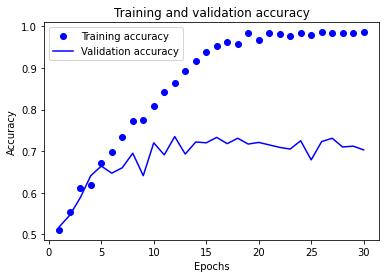

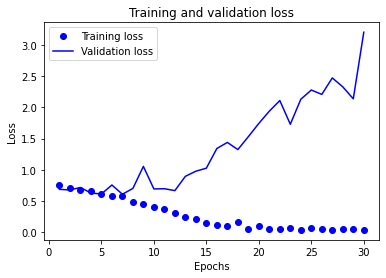

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# **Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 48ms/step - loss: 2.9643 - accuracy: 0.7000
Test accuracy: 0.700


# **Data Augmentation**

Overfitting is the number one problem in this exercise, due to the small dataset, so we are going use a regularization technique to try disminish the variance:

**Data Augmentation**: Increase the size of the data set creating new images, from the old ones, applying some transformations: flipping, rotation and zooming

In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)])

Let's look some augmented images

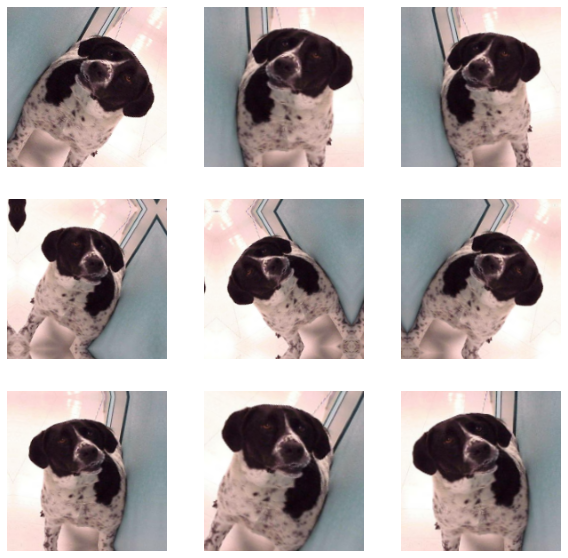

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3,i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Defining a new model**

with image augmentation and dropout

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss"
)]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 9s 121ms/step - loss: 0.7190 - accuracy: 0.5180 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 8s 118ms/step - loss: 0.7402 - accuracy: 0.5605 - val_loss: 0.6654 - val_accuracy: 0.5790
Epoch 3/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6826 - accuracy: 0.5815 - val_loss: 0.6841 - val_accuracy: 0.5760
Epoch 4/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6520 - accuracy: 0.6230 - val_loss: 0.7061 - val_accuracy: 0.5740
Epoch 5/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6301 - accuracy: 0.6665 - val_loss: 0.6554 - val_accuracy: 0.6020
Epoch 6/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6218 - accuracy: 0.6510 - val_loss: 0.6551 - val_accuracy: 0.6100
Epoch 7/100
63/63 [==============================] - 8s 116ms/step - loss: 0.6117 - accuracy: 0.6660 - val_loss: 0.6366 - val_accuracy: 0.6380

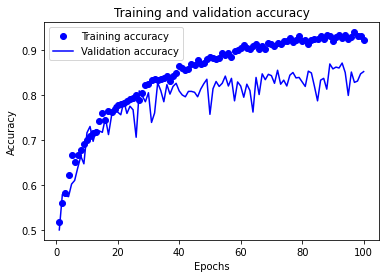

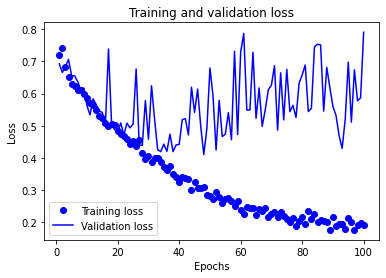

In [ ]:
#import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}") #Great improvement

63/63 [==============================] - 3s 46ms/step - loss: 0.4882 - accuracy: 0.8070
Test Accuracy: 0.807


# **Transfer Learning**:

Leveraging a pretrained model:
We will use the VGG-16 architecture. There are two ways to work with a pretrained model:
* Feature extraction
* Fine tuning 

## **Feature extraction with a pretrained model**

Feature extraction consists of using the representations learned by a previously
trained model to extract interesting features from new samples

Remember: architecture of a ConvNet:  
input -> |**Convolutional base**| -> |**Classifier**| -> output

for this task of feature extraction we are going the use the trained  **Convolutional base**  and train a new **Classifier** on top of the base.

## **Instantiating the VGG16 convolutional base**

In [ ]:
conv_bse = keras.applications.vgg16.VGG16(weights="imagenet",
                                          include_top=False,
                                          input_shape=(180,180,3))

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
conv_bse.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

The output of the above model is what we are going to pass to the classifier, but there are two ways to proceed:
* Run the convolutional base over the dataset, record its output in a numpy array on disk, and then use this data as input to a standalone, densely connected classifier: pros: Fast and cheap to run
cons: won't allow the use of data augmentation.

* Extend the model we hace by adding dense layers on top, and run the whole thing from end to end on the input data

In this exercise we are going to cover both

## **Fast feature extraction without data augmentation**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels =[]
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_bse.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(2000, 5, 5, 512)

In [ ]:
val_features.shape

(1000, 5, 5, 512)

In [ ]:
test_features.shape

(2000, 5, 5, 512)

## **Defining and training the densely connected classifier**

from the convolutional base to the classifier

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
                  filepath="feature_extraction.keras",
                  save_best_only=True,
                  monitor="val_loss"
)]

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=20, 
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 13ms/step - loss: 17.1297 - accuracy: 0.9240 - val_loss: 5.4686 - val_accuracy: 0.9650
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 3.2798 - accuracy: 0.9755 - val_loss: 4.1457 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 3.6393 - accuracy: 0.9790 - val_loss: 3.2225 - val_accuracy: 0.9740
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 0.7139 - accuracy: 0.9940 - val_loss: 3.2394 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1.3163 - accuracy: 0.9920 - val_loss: 4.1134 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.5001 - accuracy: 0.9945 - val_loss: 5.2937 - val_accuracy: 0.9780
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.5909 - accuracy: 0.9925 - val_loss: 5.8664 - val_accuracy: 0.9720
Epoch 8/20
63/

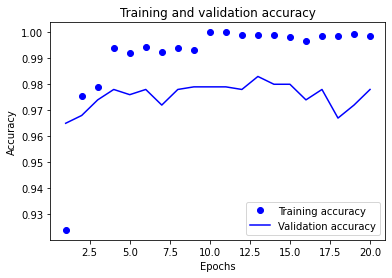

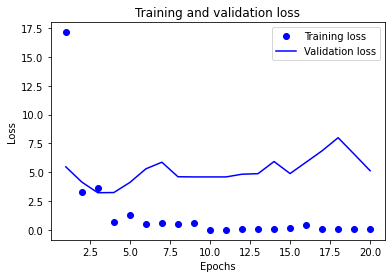

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## **Feature extraction together with data augmentation**

let's couple the convolutional base with new dense layers (for the classifier), adding the data augmentation layers.

in order to do this, we will first **freeze the convolutional base**, which means prevent the weights of the conv_base from being updated during training, which will prevent from destroying the representations previously learned; and this makes sense because we want to use that knoledge in our favor. 

### **Instantiating and freezing the VGG16 ConvBase**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
                weights="imagenet",
                include_top=False,
)
conv_base.trainable = False

In [ ]:
conv_base.trainable = True
print("Number of trainable weights before freezing: ", len(conv_base.trainable_weights))

Number of trainable weights before freezing:  26


In [ ]:
conv_base.trainable = False
print("Number of trainable weights after freezing the conv_base: ", len(conv_base.trainable_weights))

Number of trainable weights after freezing the conv_base:  0


## **Adding a data augmentation stage and a classifier to the conv_base**

In [ ]:
data_augmentation = keras.Sequential(
        [
         layers.RandomFlip("horizontal"),
         layers.RandomRotation(0.1),
         layers.RandomZoom(0.2)
        ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
#in this model we're going to trained the weights of the 2 dense layers

**Let's train the model**

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
                filepath="feature_extraction_with_data_augmentation.keras",
                save_best_only=True,
                monitor="val_loss"

)]

In [ ]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data = validation_dataset,
                    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 23s 331ms/step - loss: 17.9869 - accuracy: 0.8980 - val_loss: 13.2979 - val_accuracy: 0.9440
Epoch 2/50
63/63 [==============================] - 21s 336ms/step - loss: 7.3899 - accuracy: 0.9420 - val_loss: 4.4038 - val_accuracy: 0.9720
Epoch 3/50
63/63 [==============================] - 21s 330ms/step - loss: 6.2753 - accuracy: 0.9560 - val_loss: 4.3676 - val_accuracy: 0.9700
Epoch 4/50
63/63 [==============================] - 21s 328ms/step - loss: 4.8260 - accuracy: 0.9575 - val_loss: 5.3384 - val_accuracy: 0.9690
Epoch 5/50
63/63 [==============================] - 21s 332ms/step - loss: 3.9036 - accuracy: 0.9700 - val_loss: 2.4123 - val_accuracy: 0.9820
Epoch 6/50
63/63 [==============================] - 21s 329ms/step - loss: 3.0100 - accuracy: 0.9685 - val_loss: 4.6271 - val_accuracy: 0.9750
Epoch 7/50
63/63 [==============================] - 21s 330ms/step - loss: 3.2899 - accuracy: 0.9700 - val_loss: 4.7525 - val_accuracy: 0.97

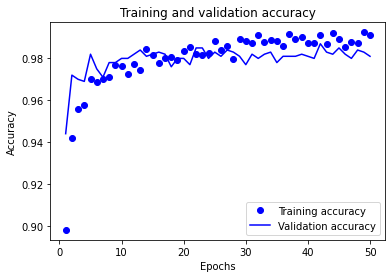

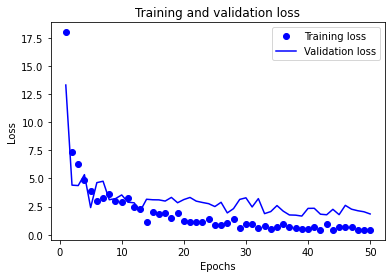

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"test Accuracy: {test_acc:.3f}")

63/63 [==============================] - 14s 206ms/step - loss: 1.9303 - accuracy: 0.9795
test Accuracy: 0.979


# **Fine Tunning a pretrained model**

This technique consists a training a part of the convolutional base (top layers) of the trained model, with the added layers of interest, in this case a Conv and the classifier.

Steps:
* add the custom network on top of the trained model.
* Freeze the base model
* Train the part we added
* Unfreeze some of the layers in the base model.
* jointly train both these layers and the part we added


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
#let's unfreeze block5_conv(1,2,3)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False


**Note**:

with the RMSprop optimizer,
using a very low learning rate. The reason for using a low learning rate is that we want to
limit the magnitude of the modifications we make to the representations of the three
layers we’re fine-tuning. Updates that are too large may harm these representations.

In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath="fine_tuning.keras",
                 save_best_only=True,
                 monitor="val_loss"
             )
]

history = model.fit(train_dataset,
                    epochs=30,
                    validation_data = validation_dataset,
                    callbacks=callbacks)